# Results
- Models used with hyperparameters 
- Best Model parameters 
- Mean Cross validation score of Best model
- Test score of best model 
- Train score of best model 

 Out of all the models,Stacking Regressor with XG Boost,Support Vector Machines,Bagging with Lassoand ridge works best with this dataset.

    The best model parameter:
         {'final_estimator__max_depth': 5, 'final_estimator__n_estimators': 500}

    Best Mean Cross-validation score: 0.8984

    Train Performance Score:  0.9482

    Test Performance Score:  0.9026
    
    train rmse: 17972.220648045088
    
    test rmse: 25870.852417706807





XG boost also gives good cross validation score  and is a much simpler model

    Best Mean Cross-validation score: 0.8981

    Best Mean Cross Validation parameters is {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.8}

    Train Performance Score:  0.9793

    Test Performance Score:  0.8776

    train rmse: 11342.06426560124

    test rmse: 29001.96379032366


## Data PreProcessing

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline

### Load Datasets

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# load dataset
# your code here
data = pd.read_csv('houseprice.csv')


### Types of variables



In [4]:
# we have an Id variable, that we should not use for predictions:

print('Number of House Id labels: ', len(data.Id.unique()))
print('Number of Houses in the Dataset: ', len(data))

Number of House Id labels:  1460
Number of Houses in the Dataset:  1460


#### Find categorical variables

In [5]:
# find categorical variables- hint data type = 'O'

categorical = [var for var in data.columns if data[var].dtype=='O']

print(f'There are {len(categorical)} categorical variables')

There are 43 categorical variables


#### Find temporal variables

In [6]:
# make a list of the numerical variables first= Hint data type != O
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information= Hint variable namme has Yr or 
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

#### Find discrete variables

To identify discrete variables- numerical variables with less than 20 unique values 

In [7]:
# let's visualise the values of the discrete variables
discrete = [var for var in numerical if len(data[var].unique()) < 20 and var not in year_vars]

print(f'There are {len(discrete)} discrete variables')

There are 14 discrete variables


#### Continuous variables

In [8]:
# find continuous variables- hint numerical variables not in discrete and  year_years 
# Also remove the Id variable and the target variable SalePrice
# which are both also numerical

continuous = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 38 numerical and continuous variables


### Separate train and test set

In [9]:
# Let's separate into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

**Now we will move on and engineer the features of this dataset. The most important part for this course.**

### Craete New Variables

Replace 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt  with time elapsed since YrSold
So YearBuilt = YrSold-YearBuilt. 

Similarly transform 'YearRemodAdd', 'GarageYrBlt.
After making transformation drop YrSold

In [10]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [11]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [12]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [13]:
year_vars.remove('YrSold')

In [14]:
# capture the column names for use later in the notebook
final_columns = X_train.columns
final_columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [15]:
pip install feature_engine

Note: you may need to restart the kernel to use updated packages.


### Feature Engineering Pipeline

In [16]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [17]:
# import relevant modules for feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from feature_engine.variable_transformers import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler
from feature_engine.discretisers import DecisionTreeDiscretiser

In [18]:
house_preprocess = Pipeline([
    
    # missing data imputation 
    ('missing_ind', mdi.AddNaNBinaryImputer(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='mean',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    # categorical encoding 
     ('rare_label_enc', ce.RareLabelCategoricalEncoder(
         tol=0.01,n_categories=6, variables=categorical+discrete)),
    ('categorical_enc', ce.MeanCategoricalEncoder(variables = categorical + discrete)),
     
    # Transforming Numerical Variables
    ('yjt', YeoJohnsonTransformer(variables = ['LotFrontage','MasVnrArea', 'GarageYrBlt'])),

    
    # discretisation and encoding
    ('treeDisc',  DecisionTreeDiscretiser(cv=2, scoring='neg_mean_squared_error',
                                   regression=True,
                                   param_grid={'max_depth': [1,2,3,4,5,6]})),

    # feature Scaling
    ('scaler', StandardScaler()),
    
    

])

In [19]:
house_preprocess.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('missing_ind',
                 AddNaNBinaryImputer(variables=['LotFrontage', 'MasVnrArea',
                                                'GarageYrBlt'])),
                ('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'MasVnrArea',
                                              'GarageYrBlt'])),
                ('imputer_cat',
                 CategoricalVariableImputer(variables=['MSZoning', 'Street',
                                                       'Alley', 'LotShape',
                                                       'LandContour',
                                                       'Utilities', '...
                                                    'Utilities', 'LotConfig',
                                                    'LandSlope', 'Neighborhood',
                                                    'Condition1', 'Condition2',
    

In [20]:
# Apply Transformations
X_train=house_preprocess.transform(X_train)
X_test=house_preprocess.transform(X_test)

## <span class="mark">DO NOT CHANGE STEPS BEFORE THIS POINT</span>

## Regression Models- Tune different models one by one

# LINEAR REGRESSION

In [21]:
# Train a linear regression model, report the coefficients and model performance 
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
cv_scores = cross_val_score(lr, X_train, y_train,)

# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(cv_scores))

# Print Co-efficients
print("lr.coef_:", lr.coef_)
print("lr.intercept_:", lr.intercept_)
#print("lr.score:",lr.best_score_)

# Check test data set performance
print("LR Train Performance Test: ", lr.score(X_train,y_train))
print("LR test Performance Test",lr.score(X_test,y_test))

X_train_preds = lr.predict(X_train)
X_test_preds = lr.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

Mean Cross-validation scores: [ 8.68250071e-01 -1.82946152e+21  8.77161153e-01  8.98296189e-01
  8.92093773e-01]
lr.coef_: [ 8.74692295e+02  9.72879918e+02  1.43598424e+03  2.41530789e+03
  1.55922446e+03  3.31539942e+02  5.84804509e+02  1.20332634e+03
  1.48520143e+03  2.33009441e+03  1.17630965e+03  1.13744157e+04
  1.26748073e+03  2.03977054e+03  1.11272495e+03 -1.03635447e+03
  1.58434519e+04 -2.93676378e+02 -5.41610661e+03  3.98221701e+03
  3.68590080e+02 -1.04048824e+03  3.19187631e+03 -2.39551624e+03
 -8.64923875e+02  2.87894951e+02  2.67846806e+03  7.08957253e+02
  1.02948711e+02  2.34865476e+03  5.71438886e+02  3.60875596e+03
  1.23986809e+03  5.64889112e+03 -1.47594682e+03  1.93575359e+03
 -2.70259491e+02  7.61385836e+03  2.15847425e+02  1.45627677e+03
  1.18463265e+03 -7.40189368e+02  1.22327269e+04  1.12776771e+04
  4.16965516e+03  5.78069444e+03  2.85514634e+03 -1.32019971e+03
  4.18391534e+03  5.24407111e+03  6.05123160e+02  3.06070473e+03
  3.74704855e+03  3.12566418e+03

# SGD REGRESSOR


In [83]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from math import sqrt
reg_sgd_pipe = Pipeline([
    ('sgd_reg', SGDRegressor(max_iter=1000, tol = 1e-6))
        ])
param_sgd = {'sgd_reg__eta0':np.linspace(0.0001,1,100), 'sgd_reg__penalty' :['l1','l2'],'sgd_reg__alpha' :[100,10,1,0.1,0.01,0.001]}
grid_sgd = GridSearchCV(reg_sgd_pipe, param_sgd,cv=5, n_jobs=-1, return_train_score = True,scoring='r2')
# Check test data set performance

grid_sgd.fit(X_train, y_train)

# let's get the predictions
X_train_preds = grid_sgd.predict(X_train)
X_test_preds = grid_sgd.predict(X_test)
print("grid_sgd.coef_:", grid_sgd.best_params_)
print("grid_sgd.score", grid_sgd.best_score_)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

grid_sgd.coef_: {'sgd_reg__alpha': 0.1, 'sgd_reg__eta0': 0.010199999999999999, 'sgd_reg__penalty': 'l2'}
grid_sgd.score 0.8836423827851494
train mse: 580454980.277078
train rmse: 24092.633319690856
train r2: 0.9070354564711168

test mse: 826521669.8658936
test rmse: 28749.289901941815
test r2: 0.8797282007955336


# RIDGE

In [23]:
# Train a Ridge regression model, report the coefficients, the best parameters, and model performance 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()
cv_scores = cross_val_score(ridge, X_train, y_train,cv=5)

#define a list of parameters
param_ridge = {'alpha':np.linspace(0.001,1000,100),'max_iter':[1,10,100,1000],'tol':[0.1,0.01,0.001,0.0001,0.00001] }

grid_ridge = GridSearchCV(ridge, param_ridge, cv=7, return_train_score = True)
grid_ridge.fit(X_train, y_train)
# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_ridge.best_score_))

print("Number of iteration:{}".format(len(cv_scores)))
print("Mean Accuracy:{}".format(cv_scores.mean()))

#find best parameters
print('Ridge parameters: ', grid_ridge.best_params_)

# print co-eff

print("Ridge.coef_:", grid_ridge.best_estimator_.coef_)
print("Ridge.intercept_:", grid_ridge.best_estimator_.intercept_)

# Check test data set performance

print("Ridge Test Performance: ", grid_ridge.score(X_test,y_test))
X_train_preds = grid_ridge.predict(X_train)
X_test_preds = grid_ridge.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

Best Mean Cross-validation score: 0.89
Number of iteration:5
Mean Accuracy:0.8818969790895619
Ridge parameters:  {'alpha': 111.11200000000001, 'max_iter': 1, 'tol': 0.1}
Ridge.coef_: [ 6.14923570e+02  1.18815132e+03  1.43374536e+03  2.66397231e+03
  1.50256700e+03  2.57909805e+02  6.77444690e+02  1.18505571e+03
  1.41272144e+03  2.23195970e+03  1.25655577e+03  9.80143992e+03
  1.22913309e+03  1.97789166e+03  1.21185105e+03 -6.37455745e+02
  1.28761649e+04 -4.74099437e+02 -2.66752274e+03  3.18082395e+03
  7.08025188e+02 -5.71762854e+02  1.70812640e+03 -1.19053599e+03
 -8.03633343e+02  8.61663506e+02  3.43176014e+03  6.86957598e+02
 -3.05551189e+02  2.74455022e+03  4.47955751e+02  3.44259635e+03
  1.38072610e+03  5.86835782e+03 -1.18908757e+03  1.82979133e+03
 -2.41222354e+02  7.77736208e+03  1.56649872e+02  1.41839632e+03
  1.23312397e+03 -5.26924115e+02  1.06539171e+04  1.00738499e+04
  3.69647792e+03  6.27870376e+03  2.52255395e+03 -1.08401246e+03
  3.79347973e+03  4.44808380e+03  8.4

# LASSO

In [24]:
# Train a Lasso regression model, report the coefficients, the best parameters, and model performance 

# YOUR CODE HERE

from sklearn.linear_model import Lasso
lasso = Lasso(random_state=11)

#define a list of parameters

param_lasso = {'alpha':np.linspace(100,100000,100)}

grid_lasso = GridSearchCV(lasso, param_lasso, cv=7, return_train_score = True)
grid_lasso.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_lasso.best_score_))
print()

#find best parameters
print('Lasso parameters: ', grid_lasso.best_params_)

# print co-eff

print("Lasso.coef_:", grid_lasso.best_estimator_.coef_)
print("Lasso.intercept_:", grid_lasso.best_estimator_.intercept_)

# Check test data set performance
print("Lasso Train Performance: ", grid_lasso.score(X_train,y_train))

print("Lasso Test Performance: ", grid_lasso.score(X_test,y_test))

X_train_preds = grid_lasso.predict(X_train)
X_test_preds = grid_lasso.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

Best Mean Cross-validation score: 0.89

Lasso parameters:  {'alpha': 1109.090909090909}
Lasso.coef_: [ 5.94841396e+02  7.46183065e+02  5.43402399e+02  2.97270207e+03
  2.67105934e+02  0.00000000e+00  2.19337119e+02  5.23935000e+02
  9.65855405e+01  1.36857752e+03  6.38955344e+02  1.07178204e+04
  3.38519535e+02  1.21606364e+03  1.02208738e+03  0.00000000e+00
  1.61244090e+04 -0.00000000e+00 -0.00000000e+00  2.53218590e+03
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.72745723e+03  0.00000000e+00
  0.00000000e+00  1.25068685e+03  0.00000000e+00  3.02624383e+03
  0.00000000e+00  6.21707390e+03 -0.00000000e+00  8.26682290e+02
 -0.00000000e+00  8.20211675e+03  0.00000000e+00  4.07343171e+02
  9.51707656e+02  0.00000000e+00  1.20039329e+04  1.13400370e+04
  2.58611453e+03  6.09049609e+03  2.16389139e+03 -1.49084533e+02
  2.01193506e+03  3.79039979e+03  2.51428333e+02  1.69670258e+03
  4.09161557e+03  2.52831844e+03  1.53012663e+03  1.32

# ELASTIC NET

In [25]:
from sklearn.linear_model import ElasticNet
elastic=ElasticNet()
param_elasticnet = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,100], 'l1_ratio' :[0.2,0.4,0.6,0.8],'max_iter':[1,10,100,500]}
grid_elasticnet = GridSearchCV(elastic , param_elasticnet, cv=5, return_train_score = True)
grid_elasticnet.fit(X_train, y_train)

grid_elasticnet_train_score = grid_elasticnet.score(X_train, y_train)
grid_elasticnet_test_score = grid_elasticnet.score(X_test, y_test)

print('Training set score: ', grid_elasticnet_train_score)
print('Test score: ', grid_elasticnet_test_score)

#find best parameters
print('Best parameters: ', grid_elasticnet.best_params_)
print('Best cross-validation score:', grid_elasticnet.best_score_)
X_train_preds = grid_elasticnet.predict(X_train)
X_test_preds = grid_elasticnet.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

Training set score:  0.9102410052276642
Test score:  0.8730194756756253
Best parameters:  {'alpha': 0.1, 'l1_ratio': 0.2, 'max_iter': 100}
Best cross-validation score: 0.8840709989966689
train mse: 560440072.7690257
train rmse: 23673.615540703235
train r2: 0.9102410052276642

test mse: 872624802.3163471
test rmse: 29540.223464224964
test r2: 0.8730194756756253


# k NEIGHBORS REGRESSOR

In [26]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg=KNeighborsRegressor()
param_knn = {'n_neighbors': range(11,15)}
grid_knn = GridSearchCV(knn_reg, param_knn, cv=5, return_train_score=True)
grid_knn.fit(X_train, y_train)

print('train score: ', grid_knn.score(X_train, y_train))
print('test score: ', grid_knn.score(X_test, y_test))

#find best parameters
print('Best parameters: ', grid_knn.best_params_)
print('Best cross-validation score:', grid_knn.best_score_)
X_train_preds = grid_knn.predict(X_train)
X_test_preds = grid_knn.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))



train score:  0.843268818865971
test score:  0.7208736881444381
Best parameters:  {'n_neighbors': 11}
Best cross-validation score: 0.7988607307818896
train mse: 978603144.818226
train rmse: 31282.633278198082
train r2: 0.843268818865971

test mse: 1918188194.6087964
test rmse: 43797.12541490362
test r2: 0.7208736881444382


# POLYNOMIAL REGRESSION


In [27]:
from sklearn.preprocessing import PolynomialFeatures
pipe_poly=Pipeline([ 
    ('polynomialfeatures', PolynomialFeatures()),
    ('norm_reg', LinearRegression()) 
])
param_poly = {'polynomialfeatures__degree':[1,2]}

grid_poly = GridSearchCV(pipe_poly, param_poly,cv=5, n_jobs=-1, return_train_score = True,scoring='r2')


grid_poly.fit(X_train, y_train)

# let's get the predictions
X_train_preds = grid_poly.predict(X_train)
X_test_preds = grid_poly.predict(X_test)

# check model performance:

print('train score: ', grid_poly.score(X_train, y_train))
print('test score: ', grid_poly.score(X_test, y_test))

#find best parameters
print('Best parameters: ', grid_poly.best_params_)
print('Best score:',grid_poly.best_score_)
X_train_preds = grid_poly.predict(X_train)
X_test_preds = grid_poly.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))



train score:  0.9999955967458091
test score:  -8894633656726822.0
Best parameters:  {'polynomialfeatures__degree': 2}
Best score: -1.1113645668914994e+16
train mse: 27493.178878248375
train rmse: 165.81067178637318
train r2: 0.9999955967458091

test mse: 6.112494792154257e+25
test rmse: 7818244554984.358
test r2: -8894633656726822.0


# DECISION TREE REGRESSOR

In [28]:
from sklearn.tree import DecisionTreeRegressor
pt_tree = DecisionTreeRegressor(random_state = 0)
param_DT = {'max_depth': range(1,20),'criterion':['mse','friedman_mse','mae'],'splitter':['best']}

grid_tree = GridSearchCV(pt_tree,param_DT,cv=5)
grid_tree.fit(X_train,y_train)
print(grid_tree.best_params_)
print("Accuracy on training set: {:.3f}".format(grid_tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(grid_tree.score(X_test, y_test)))
print("Best Score:",grid_tree.best_score_)
X_train_preds = grid_tree.predict(X_train)
X_test_preds = grid_tree.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

{'criterion': 'mse', 'max_depth': 5, 'splitter': 'best'}
Accuracy on training set: 0.858
Accuracy on test set: 0.800
Best Score: 0.7615945500938354
train mse: 888179862.3715401
train rmse: 29802.346591695426
train r2: 0.8577508363568482

test mse: 1376206728.4540532
test rmse: 37097.260390142736
test r2: 0.799740448020779


# SUPPORT VECTOR MACHINES-REGRESSION

In [29]:
from sklearn.svm import SVR

param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['sigmoid'],
               'C':[0.001,0.01,0.1,0.25,0.5,1,10],
               'gamma': [0.1,1,2,5,10,100,500]},
              {'kernel':['poly'],
               'degree':[1,2,3],
               'C':[0.001,0.01,0.1,0.25,0.5,1,10],
               'gamma':[0.1,1,2,5,10,100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['sigmoid'], 'C': [0.001, 0.01, 0.1, 0.25, 0.5, 1, 10], 'gamma': [0.1, 1, 2, 5, 10, 100, 500]}, {'kernel': ['poly'], 'degree': [1, 2, 3], 'C': [0.001, 0.01, 0.1, 0.25, 0.5, 1, 10], 'gamma': [0.1, 1, 2, 5, 10, 100]}]


In [30]:
svr=SVR()
svr.fit(X_train,y_train)
X_train_preds=svr.predict(X_train)
X_test_preds=svr.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 6560591874.536995
train rmse: 80997.48066783926
train r2: -0.050731666742694026

test mse: 7148125836.73493
test rmse: 84546.58974042023
test r2: -0.04016384163712794


In [31]:
grid_search = GridSearchCV(SVR(), param_grid, cv=3,
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print('train score: ', grid_search.score(X_train, y_train))
print('test score: ', grid_search.score(X_test, y_test))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
X_train_preds = grid_search.predict(X_train)
X_test_preds = grid_search.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train score:  0.9016336525800952
test score:  0.8702806425506886
Best parameters: {'C': 10, 'degree': 1, 'gamma': 100, 'kernel': 'poly'}
Best cross-validation score: 0.89
train mse: 614182935.6028569
train rmse: 24782.714451868604
train r2: 0.9016336525800952

test mse: 891446379.3018075
test rmse: 29857.099311584298
test r2: 0.8702806425506886


## Tune Multiple Models with one GridSearch

In [32]:
#model_gs = Pipeline([('Linear Regression',LinearRegression()),
#                    ('SGD Regressor',SGDRegressor(max_iter=1000, tol = 1e-6)),
#                    ('Ridge',Ridge()),
#                   ('Lasso',Lasso()),
#                    ('K Nearest neighbors',KneighborsRegressor()),
#                    ('Polynomial Regression', POlynomialFeatures()),
#                    ('Decision Tree Regressor',DecisionTreeRegressor()),
#                    ('Support Vector Machine',SVR())])

In [33]:
#model_parm_gd = [
#   { 'sgd_reg__eta0':np.linspace(0.0001,1,100), 'sgd_reg__penalty' :['l1','l2'],'sgd_reg__alpha' :[100,10,1,0.1,0.01,0.001]} ,
    
## {'regressor__ridge':np.linspace(0.001,1,100)},
    
#   {'regressor__alpha':np.linspace(100,100000,100)},
#   {'regressor_elasticnet':{'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,100], 'l1_ratio' :[0.2,0.4,0.6,0.8],'max_iter':[1,10,100,500]}},
#    {'regressor_knn':{'n_neighbors': range(11,15)}},
#    {'regressor_poly':{'polynomialfeatures__degree':range(1,3)}},
#   {'regressor_decisiontree':{'max_depth': range(1,30),'criterion':['mse','friedman_mse','mae'],'splitter':['best']}},
#    {'regressor_SVM':{'kernel': ['rbf'],
#             'C': [0.001, 0.01, 0.1, 1, 10, 100],
#            'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
#          {'kernel': ['sigmoid'],
#          'C':[0.001,0.01,0.1,0.25,0.5,1,10],
#         'gamma': [0.1,1,2,5,10,100,500]},
#       {'kernel':['poly'],
#       'degree':[1,2,3],
#      'C':[0.001,0.01,0.1,0.25,0.5,1,10],
#     'gamma':[0.1,1,2,5,10,100]}}
 
#]

In [34]:
#grid_search_house_pipe = GridSearchCV(model_gs, model_parm_gd)

In [35]:
#grid_search_house_pipe.fit(X_train,y_train)

In [36]:
#print(grid_search_house_pipe.best_params_)

In [37]:
# let's get the predictions
#X_train_preds = grid_search_house_pipe.predict(X_train)
#X_test_preds = grid_search_house_pipe.predict(X_test)

In [38]:
#print("Best Mean Cross-validation score: {}".format(grid_search_house_pipe.best_score_))

In [39]:
# check model performance:
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score

#print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
#print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
#print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
#print()
#print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
#print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
#print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

# Bagging with Decision Tree:

In [40]:
from sklearn.ensemble import BaggingRegressor

In [41]:
bag_dtree1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), bootstrap=True, random_state=0, oob_score=True)

bag_dtree1_param = {
                 'base_estimator__max_depth': range(1,20),
                 'base_estimator__criterion':['mse'],
                 'base_estimator__splitter':['best'],
                 #'max_samples':  [0.8,1],
                 'n_estimators': [10,25,50,75,100]
                }
bag_dtree1_grid = GridSearchCV(bag_dtree1, bag_dtree1_param,cv=5, return_train_score=True, )
bag_dtree1_grid.fit(X_train,y_train)
X_train_preds = bag_dtree1_grid.predict(X_train)
X_test_preds = bag_dtree1_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {bag_dtree1_grid.best_score_}')

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

Best Mean Cross Validation Score is 0.8767328230456084
train mse: 112489681.24936168
train rmse: 10606.115276073595
train r2: 0.9819838708868264

test mse: 875341170.146963
test rmse: 29586.165181499324
test r2: 0.8726242017727133


# Bagging with lasso

In [42]:
bag_Lasso = BaggingRegressor(base_estimator=Lasso(), bootstrap=True, random_state=0, oob_score=True)

param_lasso = {'base_estimator__alpha':[1,10,100,1000],
               'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
bag_lasso_grid = GridSearchCV(bag_Lasso,param_lasso,cv=5, return_train_score=True, )
bag_lasso_grid.fit(X_train,y_train)
X_train_lasso = bag_lasso_grid.predict(X_train)
X_test_lasso = bag_lasso_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {bag_lasso_grid.best_score_}')
print('train mse: {}'.format(mean_squared_error(y_train, X_train_lasso)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_lasso))))
print('train r2: {}'.format(r2_score(y_train, X_train_lasso)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_lasso)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_lasso))))
print('test r2: {}'.format(r2_score(y_test, X_test_lasso)))


Best Mean Cross Validation Score is 0.8871946128761892
train mse: 599465587.3235846
train rmse: 24483.98634462094
train r2: 0.9039907545280965

test mse: 814194000.0304563
test rmse: 28534.084881601797
test r2: 0.8815220691055408


# Pasting with Decision Tree

In [43]:
paste_dtree2 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), bootstrap=False, random_state=0, oob_score=False)

paste_dtree2_param = {
                 'base_estimator__max_depth': range(1,20),
                 'base_estimator__criterion':['mse','friedman_mse','mae'],
                 'base_estimator__splitter':['best'],
                # 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
paste_dtree2_grid = GridSearchCV(paste_dtree2, paste_dtree2_param,cv=5, return_train_score=True, )
paste_dtree2_grid.fit(X_train,y_train)
X_train_tree = paste_dtree2_grid.predict(X_train)
X_test_tree = paste_dtree2_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {paste_dtree2_grid.best_score_}')

print('train mse: {}'.format(mean_squared_error(y_train, X_train_tree)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_tree))))
print('train r2: {}'.format(r2_score(y_train, X_train_tree)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_tree)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_tree))))
print('test r2: {}'.format(r2_score(y_test, X_test_tree)))

Best Mean Cross Validation Score is 0.775646772225442
train mse: 304051374.8453328
train rmse: 17437.06898665406
train r2: 0.9513037216799604

test mse: 1181081171.277053
test rmse: 34366.86152788836
test r2: 0.8281342611391447


# Pasting with Lasso

In [44]:
bag_Lasso2 = BaggingRegressor(base_estimator=Lasso(), bootstrap=False, random_state=0, oob_score=False)

param_lasso2 = {'base_estimator__alpha':np.linspace(100,100000,100),
               'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
paste_lasso2_grid = GridSearchCV(bag_Lasso2,param_lasso2,cv=5, return_train_score=True, )
paste_lasso2_grid.fit(X_train,y_train)
X_train_lasso2 = paste_lasso2_grid.predict(X_train)
X_test_lasso2 = paste_lasso2_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {paste_lasso2_grid.best_score_}')

print('train mse: {}'.format(mean_squared_error(y_train, X_train_lasso2)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_lasso2))))
print('train r2: {}'.format(r2_score(y_train, X_train_lasso2)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_lasso2)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_lasso2))))
print('test r2: {}'.format(r2_score(y_test, X_test_lasso2)))


Best Mean Cross Validation Score is 0.88515334918512
train mse: 597848946.9262835
train rmse: 24450.949816444423
train r2: 0.9042496725177633

test mse: 795373680.6998224
test rmse: 28202.370125573176
test r2: 0.884260719222077


# Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor
rfc =RandomForestRegressor(random_state=42)
rfc_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
    #'criterion' :['gini', 'entropy']
}

rfc_grid = GridSearchCV(rfc, rfc_param,cv=5, return_train_score=True, )
rfc_grid.fit(X_train,y_train)
X_train_rfc = rfc_grid.predict(X_train)
X_test_rfc = rfc_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {rfc_grid.best_score_}')

print('train mse: {}'.format(mean_squared_error(y_train, X_train_rfc)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_rfc))))
print('train r2: {}'.format(r2_score(y_train, X_train_rfc)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_rfc)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_rfc))))
print('test r2: {}'.format(r2_score(y_test, X_test_rfc)))

Best Mean Cross Validation Score is 0.8684018451123624
train mse: 300882919.1206449
train rmse: 17345.977029866175
train r2: 0.9518111754018606

test mse: 948246575.1996439
test rmse: 30793.612571435067
test r2: 0.8620153277926287


# AdaBoost Regressor

In [46]:
from sklearn.ensemble import AdaBoostRegressor
adc_dtree =AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),random_state=42)
adc_dtree_param = {
              'base_estimator__max_depth': range(1,20),
              'base_estimator__criterion' : ["mse", "mae"],
              'base_estimator__splitter' :   ["best", "random"],
              'base_estimator__max_depth' : [2,4,6],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2],
             }
adc_dtree_grid = GridSearchCV(adc_dtree, adc_dtree_param,cv=5, return_train_score=True, )
adc_dtree_grid.fit(X_train,y_train)
X_train_adc = adc_dtree_grid.predict(X_train)
X_test_adc = adc_dtree_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {adc_dtree_grid.best_score_}')

print('train mse: {}'.format(mean_squared_error(y_train, X_train_adc)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_adc))))
print('train r2: {}'.format(r2_score(y_train, X_train_adc)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_adc)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_adc))))
print('test r2: {}'.format(r2_score(y_test, X_test_adc)))

Best Mean Cross Validation Score is 0.8731237811314138
train mse: 235379896.34787902
train rmse: 15342.095565726313
train r2: 0.9623020124499386

test mse: 894488734.2279433
test rmse: 29908.00451765285
test r2: 0.8698379324389933


# Gradient Boosting Regressor

In [47]:
from  sklearn.ensemble import GradientBoostingRegressor
gbc= GradientBoostingRegressor(random_state=42)
gbc_param = {
              'max_depth' : [2,3,4],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2],
             }
gbc_grid = GridSearchCV(gbc, gbc_param,cv=5, return_train_score=True, )
gbc_grid.fit(X_train,y_train)
X_train_gbc = gbc_grid.predict(X_train)
X_test_gbc = gbc_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {gbc_grid.best_score_}')
print('train mse: {}'.format(mean_squared_error(y_train, X_train_gbc)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_gbc))))
print('train r2: {}'.format(r2_score(y_train, X_train_gbc)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_gbc)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_gbc))))
print('test r2: {}'.format(r2_score(y_test, X_test_gbc)))

Best Mean Cross Validation Score is 0.8693214037454589
train mse: 96478319.6971917
train rmse: 9822.337791849337
train r2: 0.9845482194901631

test mse: 800621519.0582533
test rmse: 28295.256122860123
test r2: 0.8834970768587678


# Extra-Trees Regressor:


In [48]:
from  sklearn.ensemble import ExtraTreesRegressor
etc= ExtraTreesRegressor(random_state=42)
etc_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
    'criterion' :['mse', 'mae']
}
etc_grid = GridSearchCV(etc, etc_param,cv=5, return_train_score=True, )
etc_grid.fit(X_train,y_train)
X_train_etc = etc_grid.predict(X_train)
X_test_etc = etc_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {etc_grid.best_score_}')
print('train mse: {}'.format(mean_squared_error(y_train, X_train_etc)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_etc))))
print('train r2: {}'.format(r2_score(y_train, X_train_etc)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_etc)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_etc))))
print('test r2: {}'.format(r2_score(y_test, X_test_etc)))

Best Mean Cross Validation Score is 0.8670305610889916
train mse: 170102255.64205065
train rmse: 13042.325545777894
train r2: 0.9727567527434288

test mse: 994958957.0680267
test rmse: 31542.970010257857
test r2: 0.8552179473762773


# XGBoost Regressor

In [49]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [77]:
from  xgboost import XGBRegressor
xgbc= XGBRegressor(random_state=42,objective= 'reg:squarederror')
xgbc_param = {
              'max_depth' : [2,4,6],
              'n_estimators' : [50,100,150],
              'learning_rate' : [0.1,0.5,0.6,0.8],
               'min_child_weight' : [1,3,5,7],
                'subsample':[0.6,0.7,0.8,0.9,1]
             }
xgbc_grid = GridSearchCV(xgbc, xgbc_param,cv=5, return_train_score=True, )
xgbc_grid.fit(X_train,y_train)
X_train_xgbc = xgbc_grid.predict(X_train)
X_test_xgbc = xgbc_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {xgbc_grid.best_score_}')
print(f'Best Mean Cross Validation parameters is {xgbc_grid.best_params_}')
print('train mse: {}'.format(mean_squared_error(y_train, X_train_xgbc)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_xgbc))))
print('train r2: {}'.format(r2_score(y_train, X_train_xgbc)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_xgbc)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_xgbc))))
print('test r2: {}'.format(r2_score(y_test, X_test_xgbc)))

Best Mean Cross Validation Score is 0.8981992683459357
Best Mean Cross Validation parameters is {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.8}
train mse: 128642421.8050286
train rmse: 11342.06426560124
train r2: 0.979396879296572

test mse: 841113903.6952448
test rmse: 29001.96379032366
test r2: 0.8776048030903614


In [51]:
regressor={#'Linear_Regression':lr ,
             'SGD':grid_sgd,
             'ridge':grid_ridge,
             'lasso':grid_lasso,
             'elasticnet':grid_elasticnet,
             'knn':grid_knn,
             'poly':grid_poly,
             'dtree':grid_tree,
             'SVM':grid_search,
             'bag_dtree':bag_dtree1_grid,
             'paste_dtree':paste_dtree2_grid,
             'bag_lasso1':bag_lasso_grid,
             'paste_lasso2': paste_lasso2_grid,
             'rfc': rfc_grid,
             'etc': etc_grid,
             'adc_dtree':adc_dtree_grid,
             'gbc': gbc_grid,
             'xgbc': xgbc_grid}

In [52]:
regressor.keys()

dict_keys(['SGD', 'ridge', 'lasso', 'elasticnet', 'knn', 'poly', 'dtree', 'SVM', 'bag_dtree', 'paste_dtree', 'bag_lasso1', 'paste_lasso2', 'rfc', 'etc', 'adc_dtree', 'gbc', 'xgbc'])

In [53]:
results_mean_std = []
for  key, value in regressor.items():
    mean = value.cv_results_['mean_test_score'][value.best_index_]
    std=value.cv_results_['std_test_score'][value.best_index_]
     
    results_mean_std.append({
        "model": key,
        "mean": mean,
        "std": std
    })


accuracy_df = pd.DataFrame(results_mean_std, columns=['model', 'mean', 'std'])
accuracy_df.sort_values(by=['mean'], inplace=True,ascending=False)
accuracy_df

,model,mean,std
16,xgbc,8.981993e-01,9.513393e-03
7,SVM,8.883364e-01,8.717649e-03
10,bag_lasso1,8.871946e-01,8.323842e-03
2,lasso,8.858069e-01,2.615838e-02
1,ridge,8.852555e-01,2.820180e-02
11,paste_lasso2,8.851533e-01,6.050196e-03
3,elasticnet,8.840710e-01,1.038965e-02
8,bag_dtree,8.767328e-01,1.540055e-02
14,adc_dtree,8.731238e-01,1.341853e-02
15,gbc,8.693214e-01,1.946227e-02


In [54]:
predictions_all = {}
for  key, value in regressor.items():
    # Get best estimator
    best_model = value.best_estimator_
    
    # Predict test labels
    predictions = best_model.predict(X_test)
    
    # Save predictions to a list
    predictions_all[key] = predictions

In [55]:
pred = pd.DataFrame(predictions_all)

Text(0.5, 1, 'Correlation of the test set label prediction between models')

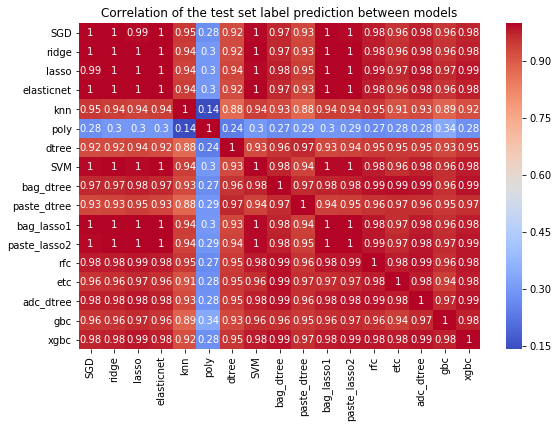

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
g = sns.heatmap(pred.corr(), annot=True, cmap='coolwarm', ax=ax)
g.set_title('Correlation of the test set label prediction between models')

In [57]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

def get_least_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]



In [71]:
print("Least Absolute Correlations")
print(get_top_abs_correlations(pred, 5))

Least Absolute Correlations
knn   poly         0.140340
poly  dtree        0.240354
      rfc          0.268573
      bag_dtree    0.271500
SGD   poly         0.276769
dtype: float64


In [72]:
print("Top Absolute Correlations")
print(get_least_abs_correlations(pred, 5))

Top Absolute Correlations
ridge       elasticnet      0.999998
lasso       paste_lasso2    0.999885
            bag_lasso1      0.999070
SGD         ridge           0.999058
bag_lasso1  paste_lasso2    0.999051
dtype: float64


# Voting Regressor- Top 5

In [76]:
from sklearn.ensemble import VotingRegressor
vclf1 = VotingRegressor(estimators=
                              [('xgb', xgbc_grid.best_estimator_), 
                               ('SVM', grid_search.best_estimator_), 
                               ('bag_lasso1', bag_lasso_grid.best_estimator_),
                               ('lasso', grid_lasso.best_estimator_),
                               ('paste_lasso', paste_lasso2_grid.best_estimator_)
                              ], )
# vclf1_param = {
#               'n_regressors' : [50,100]
#              }
#vclf1_grid = GridSearchCV(vclf1, vclf1_param,cv=5, return_train_score=True, )
vclf1.fit(X_train,y_train)
cv_scores = cross_val_score(vclf1, X_train, y_train,)

# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(np.mean(cv_scores)))
X_train_pred = vclf1.predict(X_train)
X_test_pred = vclf1.predict(X_test)
# print(f'Best Mean Cross Validation Score is {vclf1_grid.best_score_}')
# print(f'Best Mean Cross Validation Score is {vclf1_grid.best_params_}')
print(f'Train score is {vclf1.score(X_train,y_train)}')
print(f'Test score is {vclf1.score(X_test,y_test)}')
#print(f'Val score is {vclf2_grid.score(X_val,y_val)}')


Mean Cross-validation scores: 0.8958793818374555
Train score is 0.9293909676914778
Test score is 0.8861288078708559


# Voting Regressor- Least Correlated

In [75]:
vclf3 = VotingRegressor(estimators=
                              [('dtree', grid_tree.best_estimator_), 
                               ('knn', grid_knn.best_estimator_), 
                               ('bag_dtree',bag_dtree1_grid.best_estimator_),
                              ], )
# vclf3_param = {
#               'voting' : ['hard','soft'],
#              }
# vclf3_grid = GridSearchCV(vclf3, vclf3_param,cv=5, return_train_score=True, )
vclf3.fit(X_train,y_train)
cv_scores = cross_val_score(vclf3, X_train, y_train,)
X_train_pred = vclf3.predict(X_train)
X_test_pred = vclf3.predict(X_test)
# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(np.mean(cv_scores)))
# print(f'Best Mean Cross Validation Score is {vclf3_grid.best_score_}')
# print(f'Best Mean Cross Validation Score is {vclf3_grid.best_params_}')
print(f'Train score is {vclf3.score(X_train,y_train)}')
print(f'Test score is {vclf3.score(X_test,y_test)}')
#print(f'Val score is {vclf3_grid.score(X_val,y_val)}')

Mean Cross-validation scores: 0.8519439054039191
Train score is 0.9315015041975097
Test score is 0.8447191782011241


Not including knn from the above voting regressor, better score is obtained

In [74]:
vclf3 = VotingRegressor(estimators=
                              [('dtree', grid_tree.best_estimator_), 
                               #('knn', grid_knn.best_estimator_), 
                               ('bag_dtree',bag_dtree1_grid.best_estimator_),
                              ], )
# vclf3_param = {
#               'voting' : ['hard','soft'],
#              }



#vclf3_grid = GridSearchCV(vclf3,cv=5, return_train_score=True, )
vclf3.fit(X_train,y_train)
cv_scores = cross_val_score(vclf3, X_train, y_train,)
X_train_pred = vclf3.predict(X_train)
X_test_pred = vclf3.predict(X_test)

# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(np.mean(cv_scores)))
# print(f'Best Mean Cross Validation Score is {vclf3_grid.best_score_}')
# print(f'Best Mean Cross Validation Score is {vclf3_grid.best_params_}')
print(f'Train score is {vclf3.score(X_train,y_train)}')
print(f'Test score is {vclf3.score(X_test,y_test)}')
#print(f'Val score is {vclf3_grid.score(X_val,y_val)}')

Mean Cross-validation scores: 0.8417063225576576
Train score is 0.9413809818898891
Test score is 0.8537603476722619


# Stacking Regressor- top 5 models

In [70]:
from sklearn.ensemble import StackingRegressor
sclf1 = StackingRegressor(estimators=
                              [('xgb', xgbc_grid.best_estimator_), 
                               ('SVM', grid_search.best_estimator_), 
                               ('bag_lasso1', bag_lasso_grid.best_estimator_),
                               ('lasso', grid_lasso.best_estimator_),
                               ('ridge', grid_ridge.best_estimator_)
                              
                             ], final_estimator=(ExtraTreesRegressor()))
sclf1_param = {
              'final_estimator__max_depth' : [2,4,5,6,7,8],
               'final_estimator__n_estimators' : [200,500],
               #'final_estimator__max_features': ['auto', 'sqrt', 'log2'],
               #'final_estimator__criterion' :['gini', 'entropy'],
              
             }
sclf1_grid = GridSearchCV(sclf1, sclf1_param,cv=5, return_train_score=True, )
sclf1_grid.fit(X_train,y_train)
X_train_pred = sclf1_grid.predict(X_train)
X_test_pred = sclf1_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {sclf1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf1_grid.best_params_}')
print(f'Train score is {sclf1_grid.score(X_train,y_train)}')
print(f'Test score is {sclf1_grid.score(X_test,y_test)}')
#print(f'Val score is {sclf1_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8964004562245474
Best Mean Cross Validation Score is {'final_estimator__max_depth': 5, 'final_estimator__n_estimators': 500}
Train score is 0.9475888706181629
Test score is 0.9003161190546946


On running the above model excluding lasso, better score is obtained

In [79]:
from sklearn.ensemble import StackingRegressor
sclf1 = StackingRegressor(estimators=
                              [('xgb', xgbc_grid.best_estimator_), 
                               ('SVM', grid_search.best_estimator_), 
                               ('bag_lasso1', bag_lasso_grid.best_estimator_),
                               #('lasso', grid_lasso.best_estimator_),
                               ('ridge', grid_ridge.best_estimator_)
                              
                             ], final_estimator=(ExtraTreesRegressor()))
sclf1_param = {
              'final_estimator__max_depth' : [2,4,5,6,7,8],
               'final_estimator__n_estimators' : [200,500],
               #'final_estimator__max_features': ['auto', 'sqrt', 'log2'],
               #'final_estimator__criterion' :['gini', 'entropy'],
              
             }
sclf1_grid = GridSearchCV(sclf1, sclf1_param,cv=5, return_train_score=True, )
sclf1_grid.fit(X_train,y_train)
X_train_pred = sclf1_grid.predict(X_train)
X_test_pred = sclf1_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {sclf1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf1_grid.best_params_}')
print(f'Train score is {sclf1_grid.score(X_train,y_train)}')
print(f'Test score is {sclf1_grid.score(X_test,y_test)}')
#print(f'Val score is {sclf1_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8983606054800226
Best Mean Cross Validation Score is {'final_estimator__max_depth': 5, 'final_estimator__n_estimators': 200}
Train score is 0.9482688321199497
Test score is 0.9026062606779912


In [82]:
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_pred))))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_pred))))

train rmse: 17972.220648045088
test rmse: 25870.852417706807


# Stacking Regressor-Least Correlated

In [68]:
sclf2 = StackingRegressor(estimators=
                              [('dtree', grid_tree.best_estimator_), 
                               ('knn', grid_knn.best_estimator_), 
                               ('xgb', xgbc_grid.best_estimator_),
                                ('rfc', rfc_grid.best_estimator_),
                              ('bag_dtree',bag_dtree1_grid.best_estimator_),
                            ], final_estimator=(RandomForestRegressor()))
                           
sclf2_param = {
              'final_estimator__max_depth' : [2,6],
               'final_estimator__n_estimators' : [50,150],
#               'final_estimator__learning_rate' : [0.1,0.6,0.8],
#               'final_estimator__min_child_weight' : [1,3,7],
#               'final_estimator__subsample':[0.6,0.9,1],
#               'stack_method':['auto', 'predict_proba']
              }
# 'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [2,4,5,6,7,8],
sclf2_grid = GridSearchCV(sclf2, sclf2_param,cv=5, return_train_score=True, )
sclf2_grid.fit(X_train,y_train)
X_train_pred = sclf2_grid.predict(X_train)
X_test_pred = sclf2_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {sclf2_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf2_grid.best_params_}')
print(f'Train score is {sclf2_grid.score(X_train,y_train)}')
print(f'Test score is {sclf2_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8727729389915277
Best Mean Cross Validation Score is {'final_estimator__max_depth': 6, 'final_estimator__n_estimators': 50}
Train score is 0.9715273030708889
Test score is 0.8636930971422296


On running the above model excluding decision tree and XGboost Regressor, better score is obtained

In [67]:
sclf2 = StackingRegressor(estimators=
                              [#('dtree', grid_tree.best_estimator_), 
                               ('knn', grid_knn.best_estimator_), 
                               #('xgb', xgbc_grid.best_estimator_),
                                ('rfc', rfc_grid.best_estimator_),
                              ('bag_dtree',bag_dtree1_grid.best_estimator_),
                            ], final_estimator=(RandomForestRegressor()))
                           
sclf2_param = {
              'final_estimator__max_depth' : [2,6],
               'final_estimator__n_estimators' : [50,150],
#               'final_estimator__learning_rate' : [0.1,0.6,0.8],
#               'final_estimator__min_child_weight' : [1,3,7],
#               'final_estimator__subsample':[0.6,0.9,1],
#               'stack_method':['auto', 'predict_proba']
              }
# 'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [2,4,5,6,7,8],
sclf2_grid = GridSearchCV(sclf2, sclf2_param,cv=5, return_train_score=True, )
sclf2_grid.fit(X_train,y_train)
X_train_pred = sclf2_grid.predict(X_train)
X_test_pred = sclf2_grid.predict(X_test)
print(f'Best Mean Cross Validation Score is {sclf2_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf2_grid.best_params_}')
print(f'Train score is {sclf2_grid.score(X_train,y_train)}')
print(f'Test score is {sclf2_grid.score(X_test,y_test)}')
#print(f'Val score is {sclf2_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8583594564716817
Best Mean Cross Validation Score is {'final_estimator__max_depth': 6, 'final_estimator__n_estimators': 150}
Train score is 0.9631930574629979
Test score is 0.8880819192395234
